In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [32]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from gmvae import GMVAE
from circular_vae import CircularVAE
from base_vae import BaseVAE
from utils import *

In [35]:
# --- 1. Generate Synthetic Data ---
n_samples = 1000
n_features = 50
centers = 4

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=42)
X = np.abs(X).astype(np.int32).astype(np.float32) # Make counts positive 
row_sums = X.sum(axis=1)
keep_indices = row_sums > 0
X = X[keep_indices]
y = y[keep_indices]
# X = StandardScaler().fit_transform(X) # Scale for stability
X_tensor = torch.tensor(X, dtype=torch.float32)

# --- 2. Initialize Model ---
n_latent = 2
# Use blob centers as the fixed means for the prior
fixed_means = torch.tensor(make_blobs(n_samples=centers, n_features=n_latent, centers=centers, random_state=0)[0], dtype=torch.float32)

model = GMVAE(
    n_input=n_features,
    n_latent=n_latent,
    fixed_means=fixed_means
)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(f"Data shape after filtering: {X_tensor.shape}")
print(f"Minimum value in data: {X_tensor.min().item()}")

Data shape after filtering: torch.Size([1000, 50])
Minimum value in data: 0.0


In [36]:
# --- 3. Training Loop ---
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    forward_output = model(X_tensor)
    loss_dict = model.loss(X_tensor, forward_output)
    
    loss = loss_dict["loss"]
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Recon Loss: {loss_dict['recon_loss']:.4f}, KL: {loss_dict['kl_local']:.4f}")


Epoch [10/100], Loss: 135.2867, Recon Loss: 132.1016, KL: 3.1851
Epoch [20/100], Loss: 132.8142, Recon Loss: 131.1109, KL: 1.7034
Epoch [30/100], Loss: 130.4548, Recon Loss: 129.9029, KL: 0.5520
Epoch [40/100], Loss: 129.3536, Recon Loss: 128.8817, KL: 0.4718
Epoch [50/100], Loss: 128.7060, Recon Loss: 128.3059, KL: 0.4001
Epoch [60/100], Loss: 128.0167, Recon Loss: 127.5617, KL: 0.4550
Epoch [70/100], Loss: 126.7288, Recon Loss: 126.2028, KL: 0.5260
Epoch [80/100], Loss: 124.8016, Recon Loss: 124.0486, KL: 0.7530
Epoch [90/100], Loss: 122.7409, Recon Loss: 121.4992, KL: 1.2416
Epoch [100/100], Loss: 120.9245, Recon Loss: 119.1355, KL: 1.7890


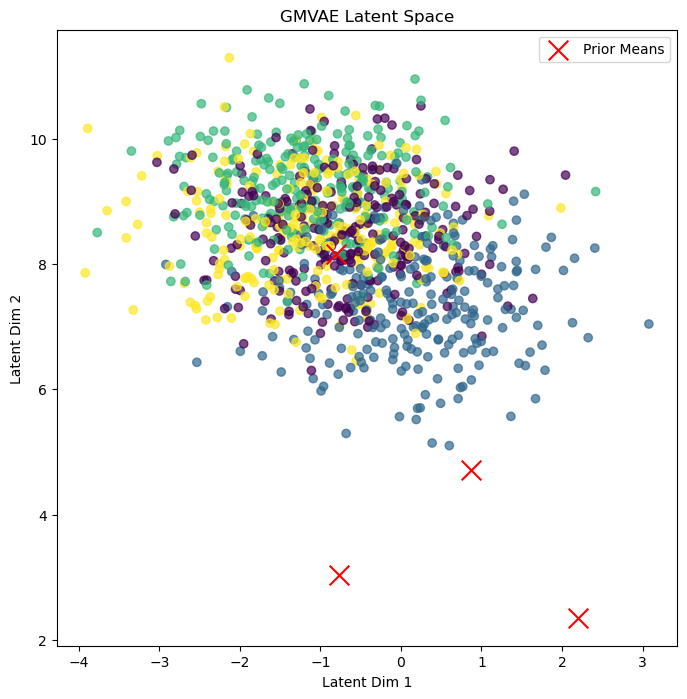

In [37]:
# --- 4. Visualize Latent Space ---
model.eval()
with torch.no_grad():
    latent_space = model(X_tensor)["z"].numpy()

plt.figure(figsize=(8, 8))
scatter = plt.scatter(latent_space[:, 0], latent_space[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.scatter(fixed_means[:, 0], fixed_means[:, 1], c='red', marker='x', s=200, label='Prior Means')
plt.title("GMVAE Latent Space")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.legend()
plt.show()